In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential


In [ ]:
CSV_PATH = './../data/GOOGL.csv'
DATE_COL = 'Date'

SEQ_LENGTH = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 100

# FEATURES = [
#     'Open', 'High', 'Low', 'Close', 'Volume',
#     'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
#     'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
#     'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
# ]

FEATURES = [
    'Close', 'Volume',
    'rsi', 'MACD_12_26_9', 'MACDs_12_26_9',
    'ema_10','ema_20'
]

TARGET = 'returns'

TRAINING_RANGE = ('2015-01-01', '2024-12-31')
TESTING_RANGE = ('2025-01-01', '2025-10-20')

In [88]:


df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
# df[f"next_{TARGET}"] = df[TARGET].shift(1)
# df = df[[DATE_COL] + FEATURES + [f"next_{TARGET}"]]
df = df[[DATE_COL] + FEATURES + [TARGET]]
df.dropna(inplace=True)
print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))

scaler = MinMaxScaler()
feature_data = scaler.fit_transform(df[FEATURES])
target_data = df[f"{TARGET}"].values

print(tb.tabulate(feature_data[:5], headers=FEATURES, tablefmt='psql'))

+----+---------------------+---------+-----------+---------+----------------+-----------------+----------+----------+-------------+
|    | Date                |   Close |    Volume |     rsi |   MACD_12_26_9 |   MACDs_12_26_9 |   ema_10 |   ema_20 |     returns |
|----+---------------------+---------+-----------+---------+----------------+-----------------+----------+----------+-------------|
|  0 | 2004-10-28 00:00:00 | 4.8042  | 593278128 | 82.5206 |       0.421614 |        0.316699 |  4.22416 |  3.86713 |  0.0394149  |
|  1 | 2004-10-29 00:00:00 | 4.73809 | 845653500 | 79.6037 |       0.438451 |        0.34105  |  4.31761 |  3.95008 | -0.0137608  |
|  2 | 2004-11-01 00:00:00 | 4.87205 | 488507004 | 81.0643 |       0.457332 |        0.364306 |  4.41841 |  4.03788 |  0.0282731  |
|  3 | 2004-11-02 00:00:00 | 4.84322 | 453398148 | 79.7408 |       0.464613 |        0.384367 |  4.49565 |  4.11458 | -0.00591743 |
|  4 | 2004-11-03 00:00:00 | 4.76369 | 554992452 | 76.052  |       0.458679 

In [89]:
X, y = [], []
dates = []
for i in range(SEQ_LENGTH, len(feature_data)):
    tmp = feature_data[i - SEQ_LENGTH:i]
    X.append(tmp)
    dates.append(df[DATE_COL].values[i])
    y.append(target_data[i])

X, y = np.array(X), np.array(y)

print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")

Feature data shape: (5227, 50, 7)
Target data shape: (5227,)


In [90]:
def find_closest_date_index(dates_array, target_date):
    target_date = np.datetime64(target_date)
    index = np.argmin(np.abs(dates_array - target_date))
    return index

train_beg, train_end = find_closest_date_index(dates, TRAINING_RANGE[0]), find_closest_date_index(dates, TRAINING_RANGE[1])
test_beg, test_end = find_closest_date_index(dates, TESTING_RANGE[0]), find_closest_date_index(dates, TESTING_RANGE[1])

print(f"Training: beg_idx={train_beg} -> beg={dates[train_beg]} || end_idx={train_end} -> end={dates[train_end]}")
print(f"Testing:  beg_idx={test_beg} -> beg={dates[test_beg]} || end_idx={test_end} -> end={dates[test_end]}")

X_train, y_train = X[train_beg:train_end+1], y[train_beg:train_end+1]
X_test, y_test = X[test_beg:test_end+1], y[test_beg:test_end+1]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training: beg_idx=2511 -> beg=2014-12-31T00:00:00.000000000 || end_idx=5027 -> end=2024-12-31T00:00:00.000000000
Testing:  beg_idx=5027 -> beg=2024-12-31T00:00:00.000000000 || end_idx=5226 -> end=2025-10-17T00:00:00.000000000
X_train shape: (2517, 50, 7), y_train shape: (2517,)
X_test shape: (200, 50, 7), y_test shape: (200,)


In [91]:
def create_model():
    model = Sequential()
    
    model.add(Input(shape=(SEQ_LENGTH, len(FEATURES))))
    
    model.add(LSTM(96, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(96, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(96, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(96))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="mse",
        metrics=["mae"]
    )
    model.summary()
    return model

model = create_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 50, 96)         │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,369 (1.00 MB)

 Trainable params: 262,369 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 4.3676e-04 - mae: 0.0148
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.5091e-04 - mae: 0.0133
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 3.4897e-04 - mae: 0.0133
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 3.4484e-04 - mae: 0.0131
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 3.4127e-04 - mae: 0.0131
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 3.4210e-04 - mae: 0.0130
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 3.3885e-04 - mae: 0.0130
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 3.4390e-04 - mae: 0.0131
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 3.3641e-04 - mae: 0.0128
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.3875e-04 - mae: 0.0129
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.3336e-04 - mae: 0.0127
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
+----+---------------------+-------------+-------------+
|    | Date                |      Actual |   Predicted |
|----+---------------------+-------------+-------------|
|  0 | 2024-12-31 00:00:00 | -0.0101443  | 0.000189125 |
|  1 | 2025-01-02 00:00:00 |  0.00068666 | 0.000241763 |
|  2 | 2025-01-03 00:00:00 |  0.0124585  | 0.00030932  |
|  3 | 2025-01-06 00:00:00 |  0.0264873  | 0.000357119 |
|  4 | 2025-01-07 00:00:00 | -0.00700964 | 0.000347936 |
+----+---------------------+-------------+-------------+
Test MSE: 0.0004232646026883309
Test MAE: 0.014798366634580251
Test R2: -0.007098137280782568
Direction Prediction Accuracy: 51.00%


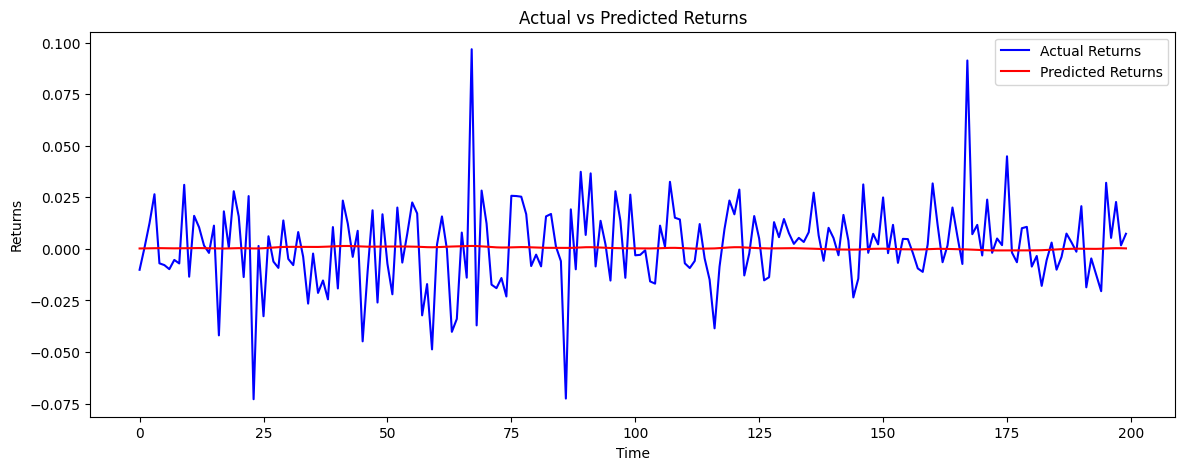

In [93]:
predictions = model.predict(X_test)

comp_df = pd.DataFrame({
    'Date': df[DATE_COL].values[test_beg + SEQ_LENGTH:test_end + SEQ_LENGTH + 1],
    'Actual': y_test,
    'Predicted': predictions.flatten()
})
print(tb.tabulate(comp_df.head(), headers='keys', tablefmt='psql'))


mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R2: {r2}")

direction_correct = np.sum((np.sign(y_test) == np.sign(predictions.flatten())).astype(int))
direction_accuracy = direction_correct / len(y_test)
print(f"Direction Prediction Accuracy: {direction_accuracy * 100:.2f}%")

plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Returns')
plt.plot(predictions, color='red', label='Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()